In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(scales)
library(data.table)
library(ggrepel)
my_theme = my_theme + theme(legend.key.size = unit(0.5, 'lines'))

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.0     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




In [2]:
win_size = 1000000
chrom= "chr12"
prop_acc=0.4
data_path="../../output/greatapes-diversity-data/"
outpath="../../output/final_figs/"
f_prefix="long-cor"
neutral_cov_path="../../output/joined_stats/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_sample-size_10_joinedcovs.tsv"
dir.create(outpath, recursive=T)

Warning message in dir.create(outpath, recursive = T):
"'../../output/final_figs' already exists"


In [3]:
pidxy_csv_path = paste0(data_path,chrom,"/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv")

In [4]:
pidxy = fread(pidxy_csv_path, header =T)

In [5]:
p_rec = ggplot(pidxy, aes(x=start,y=mean_rec)) + geom_line() +
    labs(x="", y="Recombination rate (cM/Mb)") +
    xlim(0, 1.8e8) +
    my_theme
p_ex = ggplot(pidxy, aes(x=start,y=ex_overlap/100)) + geom_line() +
    labs(x="", y="Exon density") + 
    scale_y_continuous(labels = scales::percent) + 
    xlim(0, 1.8e8) +
    my_theme

In [6]:
land_rds_path = paste0(data_path,chrom,"/subset-",chrom,"-landscapes_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.rds")
land_rds = readRDS(land_rds_path)
#land_rds+ my_theme + labs(subtitle="", x="Position")


pdf(paste0(outpath,"pidxy-ex-rec-land_",chrom,"_data.pdf"), width = 6.5*1.2, height = 6.0*1.2)
(land_rds+ my_theme + labs(subtitle="", x="", y="Per site differences")+ scale_y_continuous(labels = scales::percent)) / (p_ex + p_rec)+
  plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Position", y = 0.02, x=0.54))
dev.off()
#ggsave(filename=paste0(outpath,"pidxy-land_",chrom,"_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

Warning message:
"The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
i Please use "none" instead."


png 
  2

## Figure 3

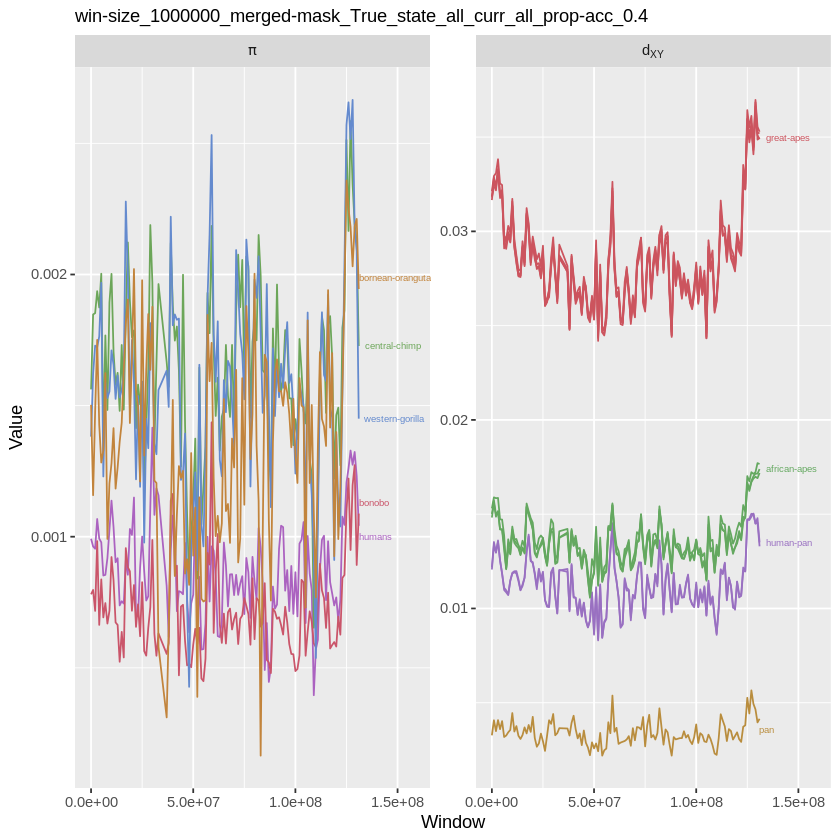

In [7]:
land_rds

In [8]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)

In [9]:
# resorting the spp combos -- will be needed to join with the neutral cov
df$combo1 = apply(df, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
df$combo2 = apply(df, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
df[,c("combo1","combo2")] = t(apply(df,1, function(x) sort(unlist(x[c("combo1", "combo2")]))))

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
i Please use tidy evaluation ideoms with `aes()`"
Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4."


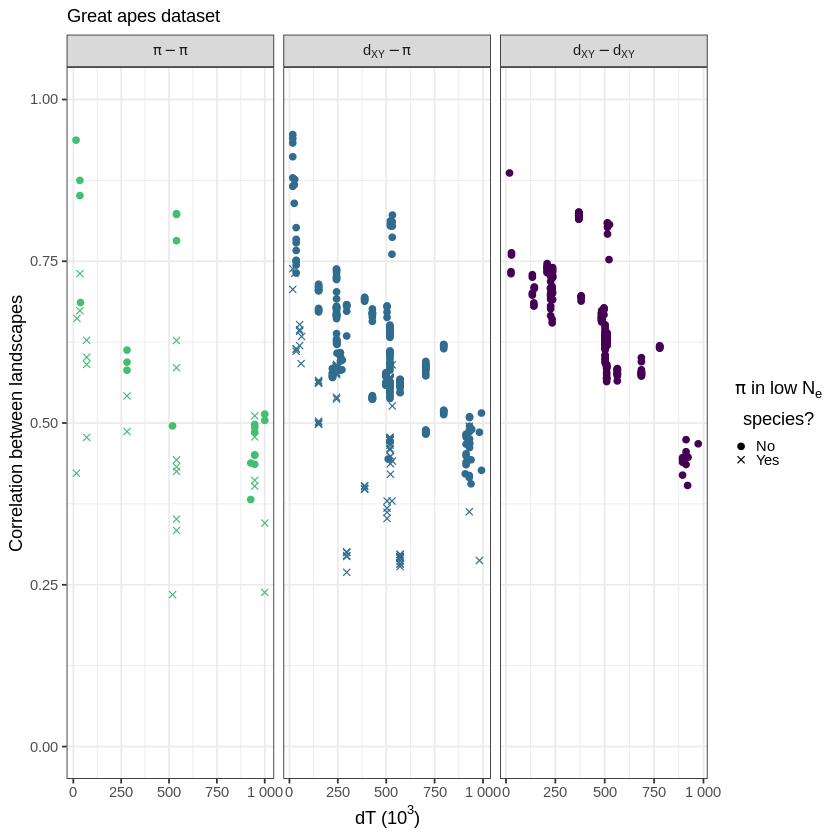

In [10]:
corr_dt_panel = function(df,subt="", x_colname="dt", end=0.7, dxydxylab="d[XY]-d[XY]") {
    statcombolabs = c(`dxy_dxy`=dxydxylab, `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    p_dt = ggplot(df[df$has_shared == FALSE,], aes_string(y="value", x=x_colname, label="stat_combo1", label2="stat_combo2", shape="lowne", col="statcombo")) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_x_continuous(labels = label_number(scale = 1e-3)) +
        scale_color_viridis_d(direction=1, end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")),
            subtitle=subt) +
        ylim(0,1) +
        guides(shape = guide_legend(title.position="top"), color=FALSE)+
        my_theme
    return(p_dt)
}
df$label = round(df$value,2)

corr_dt_panel(df, subt="Great apes dataset")#+ geom_text_repel(data = df[(df$stat_combo1=="pi_humans" & df$stat_combo2=="pi_western-gorilla"),],aes(label = label))
ggsave(filename=paste0(outpath,"cor-pidxy-dT_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [11]:
a="sqsqpxpy"
df[,a]**2

[1] 0.31695306 0.08594656 0.00000000 0.00000000 0.00000000 0.11395667
   [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  [13] 0.00000000 0.00000000 0.00000000 0.70710678 0.00000000 0.00000000
  [19] 0.00000000 0.11395667 0.00000000 0.00000000 0.00000000 0.00000000
  [25] 0.45214959 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  [31] 0.00000000 0.15799318 0.00000000 0.00000000 0.00000000 0.00000000
  [37] 0.00000000 0.00000000 0.08594656 0.00000000 0.00000000 0.00000000
  [43] 0.00000000 0.00000000 0.00000000 0.00000000 0.45214959 0.00000000
  [49] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  [55] 0.13558247 0.00000000 0.17976899 0.00000000 0.17976899 0.14365008
  [61] 0.00000000 0.00000000 0.09143245 0.00000000 0.09143245 0.00000000
  [67] 0.89954076 0.10834144 0.22411966 0.00000000 0.17976899 0.00000000
  [73] 0.17976899 0.14365008 0.00000000 0.75430540 0.06895871 0.35049579
  [79] 0.20718560 0.09143245 0.12676488 0.00000000 0.24923750 0.00000000
  [85] 0.24923750 0.19916108 0.00000000 0.70710678 0.00000000 0.13558247
  [91] 0.00000000 0.13558247 0.10834144 0.00000000 0.00000000 0.06895871
  [97] 0.00000000 0.75430540 0.06895871 0.35049579 0.20718560 0.09143245
 [103] 0.12676488 0.00000000 0.06895871 0.00000000 0.13558247 0.00000000
 [109] 0.29167076 0.72350759 0.34041781 0.33062363 0.00000000 0.13227667
 [115] 0.31646404 0.70434581 0.31646404 0.00000000 0.10834144 0.99261319
 [121] 0.06077339 0.00000000 0.29167076 0.72350759 0.34041781 0.33062363
 [127] 0.00000000 0.06895871 0.98193397 0.09504217 0.05618147 0.31646404
 [133] 0.25893155 0.00000000 0.22455736 0.85045056 0.29214183 0.27856286
 [139] 0.13227667 0.00000000 0.00000000 0.94355000 0.09920886 0.98031521
 [145] 0.97292840 0.70434581 0.83054641 0.96224918 0.00000000 0.06895871
 [151] 0.98193397 0.09504217 0.05618147 0.31646404 0.25893155 0.00000000
 [157] 0.96224918 0.14030251 0.96323479 0.12102268 0.08885061 0.12102268
 [163] 0.12102268 0.70710678 0.12342414 0.12102268 0.08885061 0.12102268
 [169] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [175] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [181] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [187] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [193] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [199] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [205] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [211] 0.40279191 0.93536622 0.93536622 0.08557596 0.73491204 0.93536622
 [217] 0.40279191 0.93536622 0.00000000 0.17976899 0.29167076 0.00000000
 [223] 0.00000000 0.98535351 0.39203897 0.92071973 0.92071973 0.00000000
 [229] 0.17976899 0.29167076 0.00000000 0.00000000 0.92071973 0.29774093
 [235] 0.00000000 0.38735128 0.13114830 0.29774093 0.29774093 0.71997492
 [241] 0.25423175 0.00000000 0.34041781 0.00000000 0.29167076 0.29167076
 [247] 0.39203897 0.13114830 0.29167076 0.00000000 0.17976899 0.29167076
 [253] 0.00000000 0.00000000 0.92071973 0.29774093 0.00000000 0.29167076
 [259] 0.00000000 0.34041781 0.40279191 0.40279191 0.06282687 0.41078454
 [265] 0.40279191 0.98134734 0.40279191 0.00000000 0.00000000 0.72350759
 [271] 0.00000000 0.00000000 0.39203897 0.99210557 0.39203897 0.39203897
 [277] 0.00000000 0.00000000 0.72350759 0.00000000 0.00000000 0.39203897
 [283] 0.00000000 0.00000000 0.00000000 0.73156996 0.00000000 0.00000000
 [289] 0.39981823 0.00000000 0.00000000 0.70434581 0.09657292 0.70434581
 [295] 0.70434581 0.97345291 0.71219465 0.70434581 0.00000000 0.00000000
 [301] 0.72350759 0.00000000 0.00000000 0.39203897 0.00000000 0.00000000
 [307] 0.70434581 0.13657473 0.72350759 0.98701388 0.08557596 0.73491204
 [313] 0.96823966 0.40279191 0.96823966 0.00000000 0.14365008 0.33062363
 [319] 0.08057953 0.00000000 0.92071973 0.39203897 0.98535351 0.97236739
 [325] 0.00000000 0.09143245 0.31646404 0.12601655 0.07449109

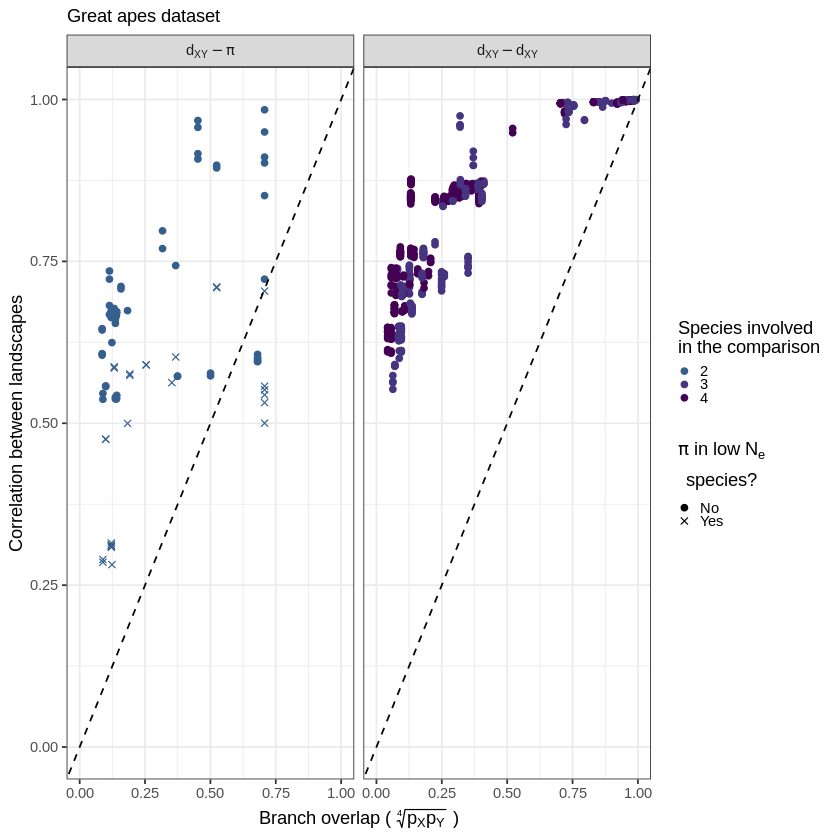

In [12]:
corr_panel = function(df,subt="", x_colname="sqsqpxpy", x_name=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), has_shared=TRUE, end=0.7) {
    #df$num_spp = as.character(df$num_spp)
    statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    df[,x_colname] = df[,x_colname]**2 # we actually want sqpxpy not sqsqpxpy (math was wrong)
    p_bo = ggplot(df[df$has_shared == has_shared,], aes(y=value, x=get(x_colname), label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
        geom_point() +
        scale_shape_manual(values=c(19, 4), labels=c("No", "Yes")) +
        scale_color_viridis_d(direction=-1,begin=0., end=end) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=x_name, y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")), 
             col="Species involved\nin the comparison", subtitle=subt) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
        xlim(0.0,1.0) +
        ylim(0.0,1.0)+
        guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top")) +
        my_theme
    return(p_bo)
}
corr_panel(df, subt="Great apes dataset", end=0.3) 
ggsave(filename=paste0(outpath,"cor-pidxy-branchoverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [13]:
# reading in neutral sim covariances
neutral_covs = read.table(neutral_cov_path, header=TRUE)
neutral_covs = neutral_covs %>%
  mutate(across(spp1_1:spp2_2, ~sub("gorila", "gorilla", .)))
neutral_covs[,c("spp1_1","spp2_1")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_1", "spp2_1")])))
neutral_covs[,c("spp1_2","spp2_2")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_2", "spp2_2")])))
neutral_covs$combo1 = apply(neutral_covs, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
neutral_covs$combo2 = apply(neutral_covs, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
neutral_covs[,c("combo1","combo2")] = t(apply(neutral_covs,1, function(x) sort(x[c("combo1", "combo2")])))
#neutral_covs

neutral_covs$corr = NA

for (i in 1:nrow(neutral_covs)) {
    # corr is cov/sqrt(var1*var2)
    # sd = cov(a,a)
    row_var_1 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo1"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo1"]) 
    row_var_2 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo2"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo2"]) 
    norm = sqrt(neutral_covs[row_var_1,"cov"])*sqrt(neutral_covs[row_var_2,"cov"])
    #print(norm)
    neutral_covs[i,"corr"] = neutral_covs[i,"cov"] / norm
}

In [14]:
df = left_join(x=df, y=neutral_covs[,c("corr","combo1","combo2")])

Joining, by = c("combo1", "combo2")


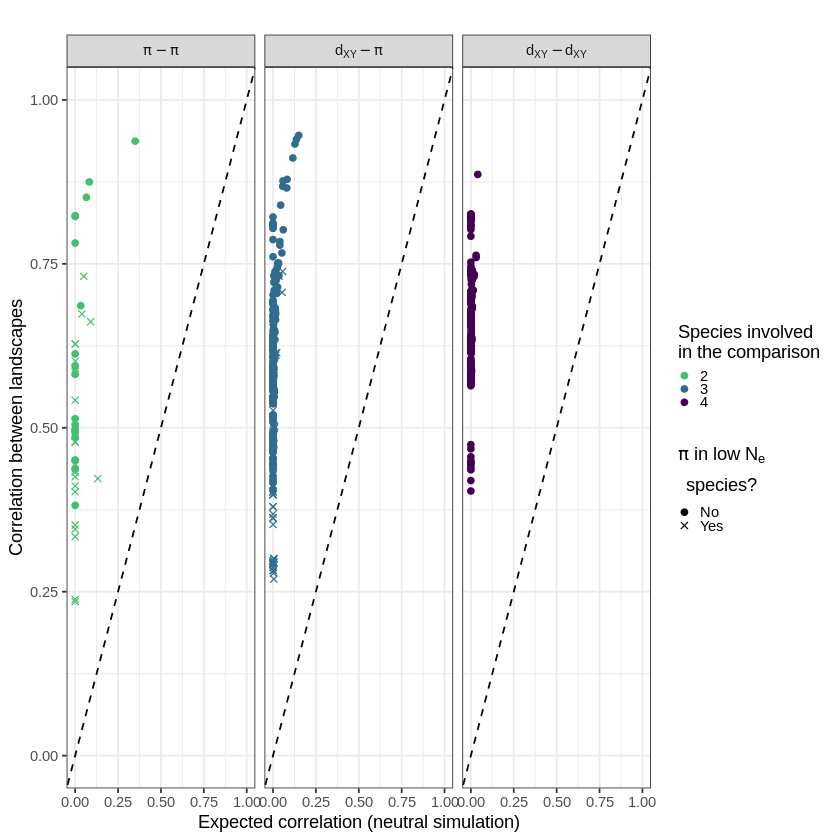

In [15]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=FALSE)
ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-nooverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

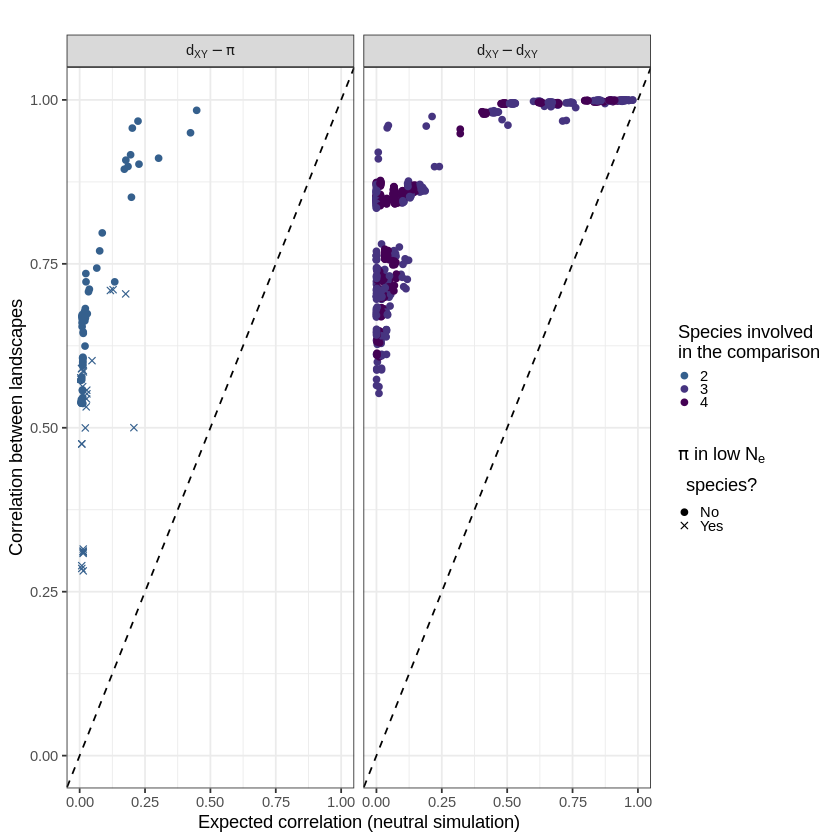

In [16]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=TRUE, end=0.3)

ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-overlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [17]:
rds_path_neutral = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/long-cor_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neudf = readRDS(rds_path_neutral)
neudf$label = round(neudf$value,2)
subneudf = neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]
subneudf$label = rev(letters[1:length(subneudf$label)])
p_neut_corr_dt_panel = corr_dt_panel(neudf, subt="Neutral simulation")+ylim(-0.25,1)+geom_abline(intercept = 0, slope = 0, linetype = "dashed") +
                        geom_text_repel(data = subneudf,
                                        aes(label = label), 
                                        min.segment.length = 0,
                                        box.padding = .85,
                                        point.padding = 0.35,
                                        nudge_x = 0,
                                        arrow = arrow(length = unit(0.02, "npc")))
ggsave(filename=paste0(outpath,"cor-pidxy-dT_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2386553,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,FALSE,3,FALSE,NA,0.24
1485,pi_central-chimp,pi_eastern-chimp,0.6180284,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [18]:
table(c("A","T","C"), c("G","G","A"))

   
    A G
  A 0 1
  C 1 0
  T 0 1

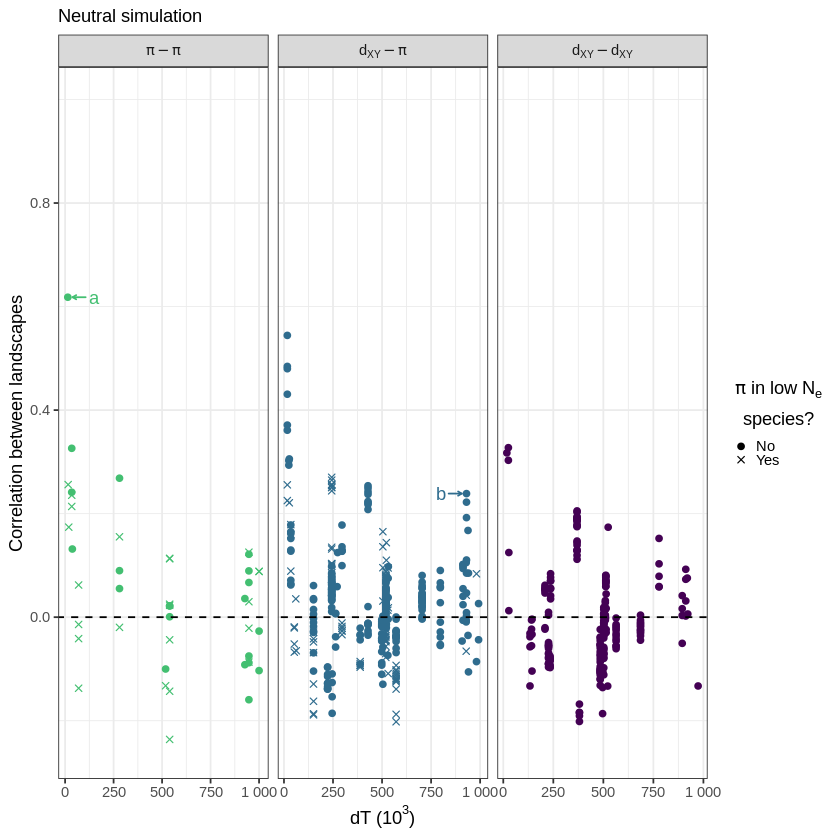

In [19]:
p_neut_corr_dt_panel

In [20]:
neudf$label = round(neudf$value,2)
neudf[(neudf$stat_combo1=="pi_central-chimp" & neudf$stat_combo2=="pi_eastern-chimp") |
      (neudf$stat_combo2=="pi_bornean-orangutan" & neudf$stat_combo1=="dxy_central-chimp western-chimp"),]

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,⋯,denom_px,denom_py,px,py,sqsqpxpy,lowne,num_spp,has_shared,harmne,label
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>
53,dxy_central-chimp western-chimp,pi_bornean-orangutan,0.2386553,chimps,dxy,central-chimp,western-chimp,bornean-orangutan,pi,bornean-orangutan,⋯,34240,18654,0,0,0,FALSE,3,FALSE,NA,0.24
1485,pi_central-chimp,pi_eastern-chimp,0.6180284,central-chimp,pi,central-chimp,central-chimp,eastern-chimp,pi,eastern-chimp,⋯,7000,7000,0,0,0,FALSE,2,FALSE,NA,0.62


In [21]:
neut_land_rds_path = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/figs/subset-chr12-landscapes_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neut_land_rds = readRDS(neut_land_rds_path)
p_neut_land = neut_land_rds+ my_theme + labs(subtitle="", x="Position", y="Per site differences")+ scale_y_continuous(labels = scales::percent)
ggsave(filename=paste0(outpath,"pidxy-land-",chrom,"_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

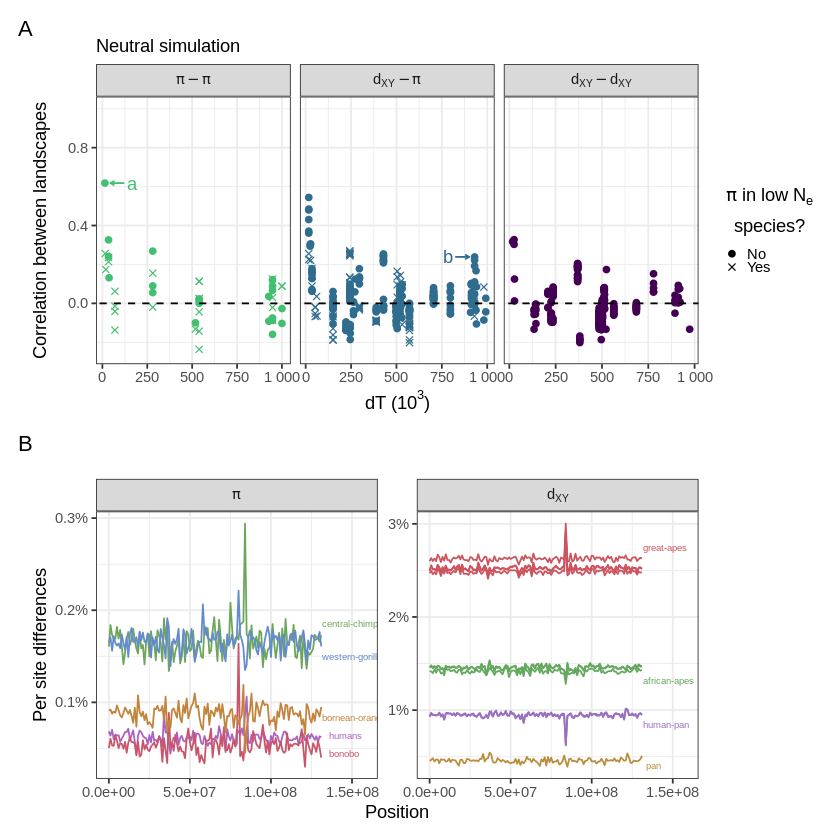

In [22]:
wrap_plots(list(p_neut_corr_dt_panel,p_neut_land), nrow=2) + plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"pidxy-corr-land-panel_neutral.pdf"), width = 6.5, height = 6, units = "in", dpi=300)

In [23]:
plot_annot_cov = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_pi_corr = ggplot(df[df$spp1==df$spp2,], aes(y=cov, x="", shape=zlowne, col=spp1)) + #sprintf("\u03c0")
        geom_point() + 
        my_theme + 
        scale_colour_manual(values=pal10col) +
        xlab("") +
        labs(shape=bquote("Includes low "*N[e]*" species?"),col="Species", y=bquote("Cov("~pi~","~.(annot)~")"))+
        scale_shape_discrete(labels=lownelabs)+
        ylim(ylims)# + theme(legend.position = 'top')
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    p = wrap_plots(annot_pi_corr, annot_dxy_corr, guides="collect", widths=c(1,4))# & theme(legend.position = 'bottom')
    return(list(annot_pi_corr, annot_dxy_corr))

}

In [24]:
plot_annotdxy_cov = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    return(annot_dxy_corr)

}

In [25]:
plot_annot_cor = function(df,ylims, annot="% Exon") {
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
    annot_pi_corr = ggplot(df[df$spp1==df$spp2,], aes(y=cor, x="", shape=zlowne, col=spp1)) + #sprintf("\u03c0")
        geom_point() + 
        my_theme + 
        scale_colour_manual(values=pal10col) +
        xlab("") +
        labs(shape=bquote("Includes low "*N[e]*" species?"),col="Species", y=bquote("Cor("~pi~","~.(annot)~")"))+
        scale_shape_discrete(labels=lownelabs)+
        ylim(ylims)# + theme(legend.position = 'top')
    annot_dxy_corr = ggplot(df[df$spp1!=df$spp2,], aes(y=cor, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cor("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims)#+ theme(legend.position = 'bottom')
    p = wrap_plots(annot_pi_corr, annot_dxy_corr, guides="collect", widths=c(1,4))# & theme(legend.position = 'bottom')
    return(list(annot_pi_corr, annot_dxy_corr))

}

In [26]:
selected_sims_chr12 = c("8MF0I020MWGI6N41PH", 
"RNX4L54J663QN2SY5X", "UTJG9R531BVSR6UA41", "CR1UIIF8NRSPZ94LGF",
"SUI6SNW0AFZ3SSL9SJ", "4GROMS6FHMNW5X9L72", "HC27BSIEQBYZJHHUQV",
"OLFRORNB6W0091FLBD", "HVD283AEPBL88J4NUN", "DFFB9J9GYC00WIFTAQ")

In [27]:
pidxy_path = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"
#pidxy_path = "../../output/sims_results/sup-rand-id_OLFRORNB6W0091FLBD_rep_0_win-size_1000000_sample-size_10/pidxy-filtered-withmetadata_sup-rand-id_OLFRORNB6W0091FLBD_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.tsv"
#pin_path = "../../output/greatapes-diversity-data/chr12/piN-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"
pidxy = fread(pidxy_path, header =T)
#pin = fread(pin_path, header =T)

In [28]:
#branches = c("eastern-central", "nigerian-western","chimps","pan", "gorilla", "human-pan","african-apes.orangutans")
#pin_cov_ex = pin %>%
#    filter(stat=="N", branch %in% branches) %>%
#    group_by(branch, gens) %>%
#    summarise(cov= cov(value, ex_overlap, method="spearman",use = "complete.obs"))

In [29]:
#pin_cov_rec = pin %>%
#    filter(stat=="N", branch %in% branches) %>%
#    group_by(branch, gens) %>%
#    summarise(cov= cov(value, mean_rec, method="spearman",use = "complete.obs"))

In [30]:
#ggplot(pin_cov_ex,aes(x=gens, y=cov, col=branch)) + geom_point()

In [31]:
#ggplot(pin_cov_rec,aes(x=gens, y=cov, col=branch)) + geom_point()

In [32]:
cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


In [33]:
cov_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, mean_rec, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


In [34]:
cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cor= cor(value, ex_overlap, method="pearson",use = "complete.obs"))
    #do(cov(.$value, .$mean_rec, method="spearman"))

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


In [35]:
cov_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>%
    summarise(cov= cov(value, ex_overlap, method="pearson",use = "complete.obs"),
             var= var(value, use = "complete.obs"),
             varx = var(ex_overlap, use = "complete.obs"),
             n = n())
    #do(cov(.$value, .$mean_rec, method="spearman"))

`summarise()` has grouped output by 'spp1', 'spp2', 'dt'. You can override using the `.groups` argument.


In [36]:
edges = fread('../../data/meta/edges_meta.tsv', sep="\t", header=T, fill=T)
edges[edges$edge == 'western_gorila']$edge = 'western_gorilla'
edges$edge = str_replace(edges$edge, "_", "-")
edges$parent = str_replace(edges$parent, "_", "-")
root = edges[edges$parent == "",]$edge
edges[edges$edge==root]$gens = edges[edges$edge==root]$N
cov_rec=dplyr::left_join(x = cov_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cov_ex=dplyr::left_join(x = cov_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_rec=dplyr::left_join(x = cor_rec, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))
cor_ex=dplyr::left_join(x = cor_ex, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("mrca"="edge"))

In [37]:
p1s=plot_annot_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
p2s=plot_annot_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")
#ggsave(filename=paste0(outpath,"cor-pidxy-rec_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)
#ggsave(filename=paste0(outpath,"cor-pidxy-ex_data.pdf"), width = 6.5, height = 3, scale=1.5, units = "in", dpi=300)

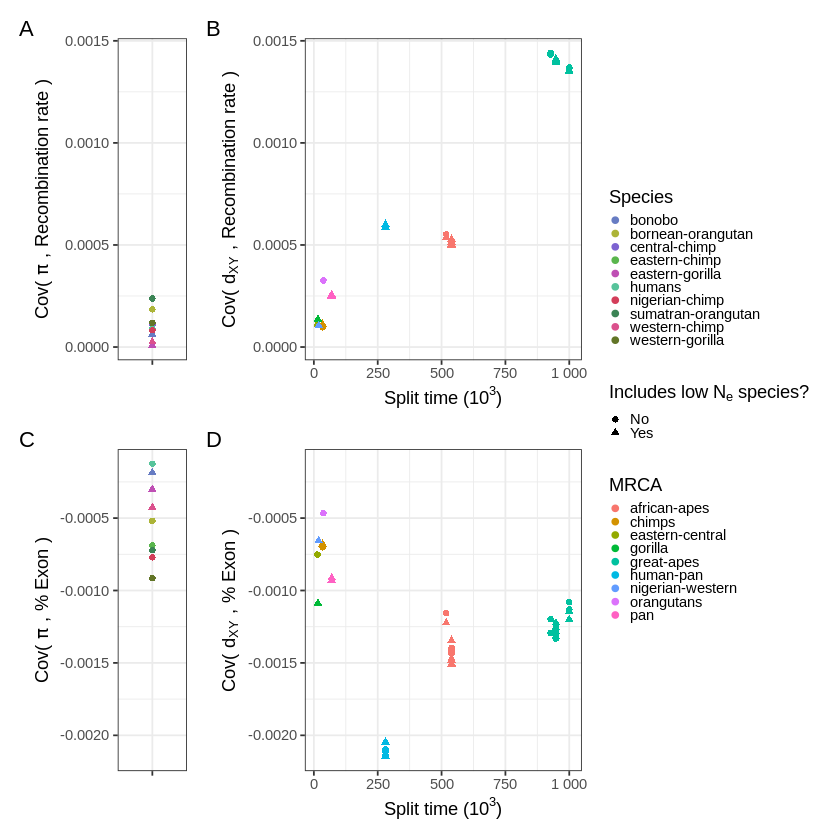

In [38]:
wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')

In [39]:
ggsave(filename=paste0(outpath,"cov-pidxy-annot_data.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

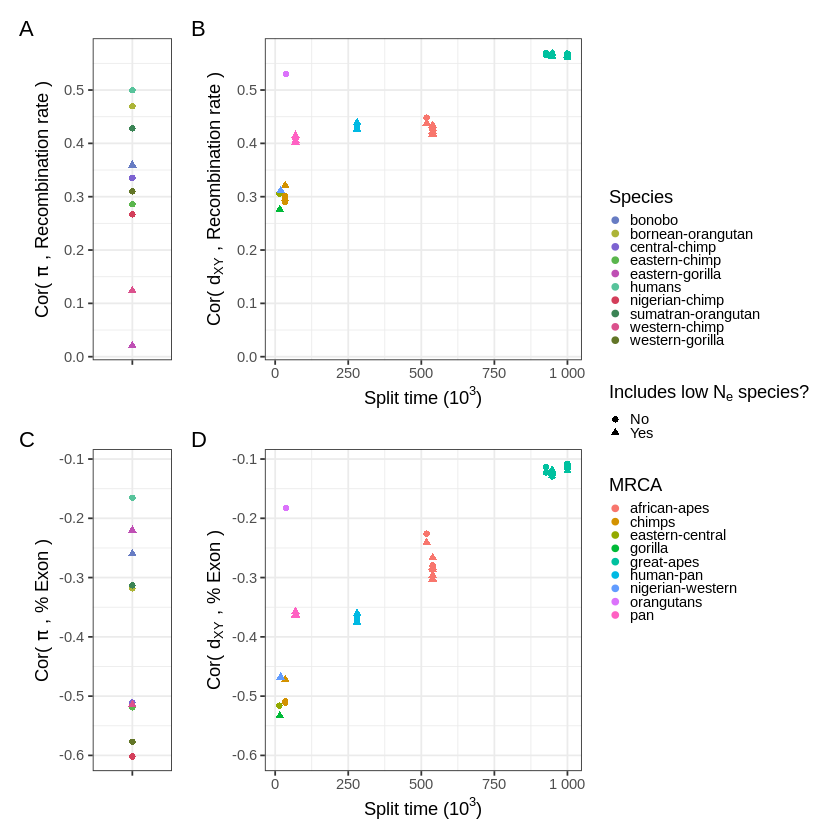

In [40]:
p1s=plot_annot_cor(cor_ex, c(min(cor_ex$cor),max(cor_ex$cor)))
p2s=plot_annot_cor(cor_rec, c(min(cor_rec$cor),max(cor_rec$cor)), annot="Recombination rate")
wrap_plots(c(p2s,p1s), widths=c(1,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data.pdf"), width = 6.5, height = 6, scale=1.25, units = "in", dpi=300)

In [41]:
pex_cov = plot_annotdxy_cov(cov_ex, c(min(cov_ex$cov),max(cov_ex$cov)))
prec_cov = plot_annotdxy_cov(cov_rec, c(min(cov_rec$cov),max(cov_rec$cov)), annot="Recombination rate")

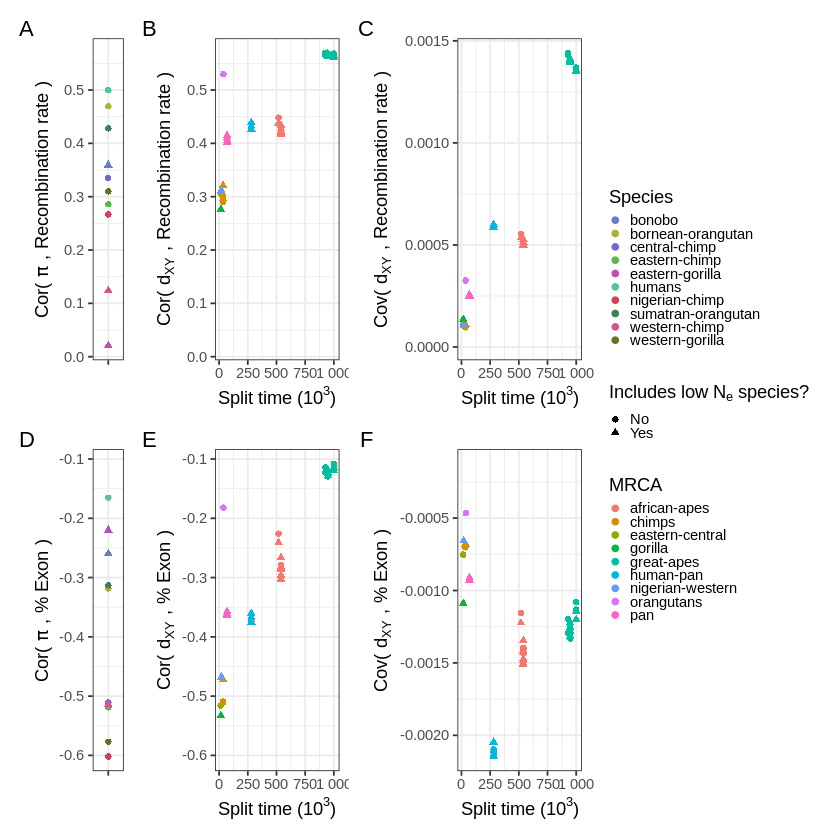

In [42]:
wrap_plots(c(append(p2s, list(prec_cov)),append(p1s, list(pex_cov))), widths=c(1,4,4), nrow=2, guides="collect")+
  plot_annotation(tag_levels = 'A')
ggsave(filename=paste0(outpath,"cor-pidxy-annot_data.pdf"), width = 6.5, height = 4, scale=1.5,
       units = "in", dpi=300)

In [43]:
csv_path_ex_correls = "../../output/greatapes-diversity-data/cor-pidxy-exon_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"

ex_corr = read.table(csv_path_ex_correls, sep="\t", header=T, quote="")

In [44]:
csv_path_rec_correls = "../../output/greatapes-diversity-data/cor-pidxy-rec-rate_win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv"


rec_corr = read.table(csv_path_rec_correls, sep="\t", header=T, quote="")


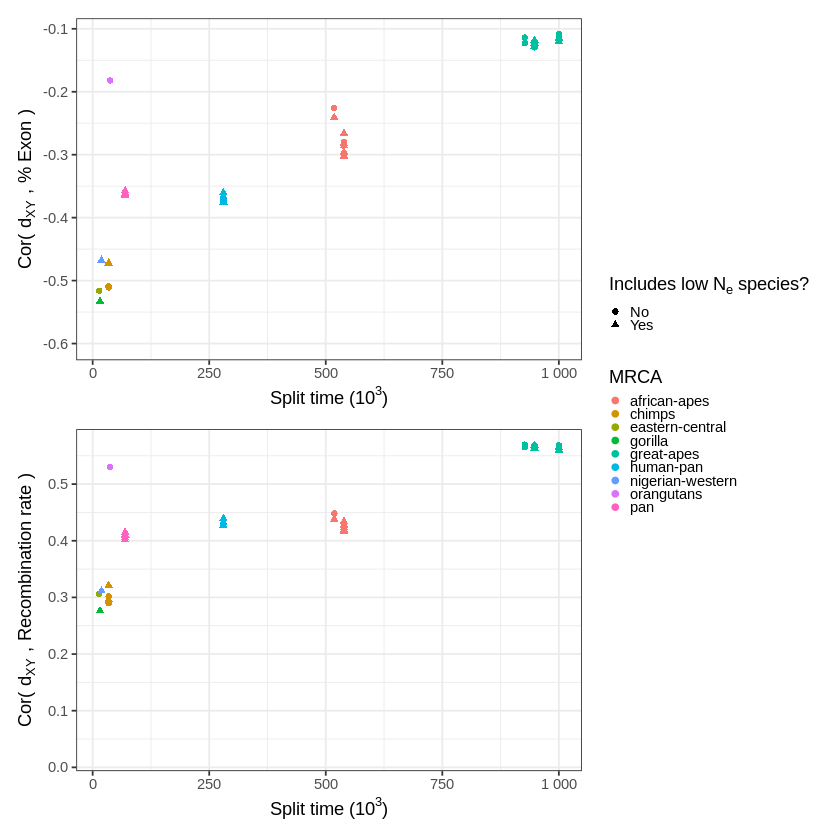

In [45]:
wrap_plots(p1s[[2]], p2s[[2]], guides="collect", nrow=2)

In [46]:
cov_rec_pi_N = ggplot(cov_rec[cov_rec$spp1==cov_rec$spp2,], aes(x=N, y=cov, col=spp1)) + geom_point()+ labs(x="N", y="Cov(Pi, Rec rate)", col="Species")

In [47]:
cov_ex_pi_N = ggplot(cov_ex[cov_ex$spp1==cov_ex$spp2,], aes(x=N, y=cov, col=spp1)) + geom_point() + labs(x="N", y="Cov(Pi, %Ex)", col="Species")

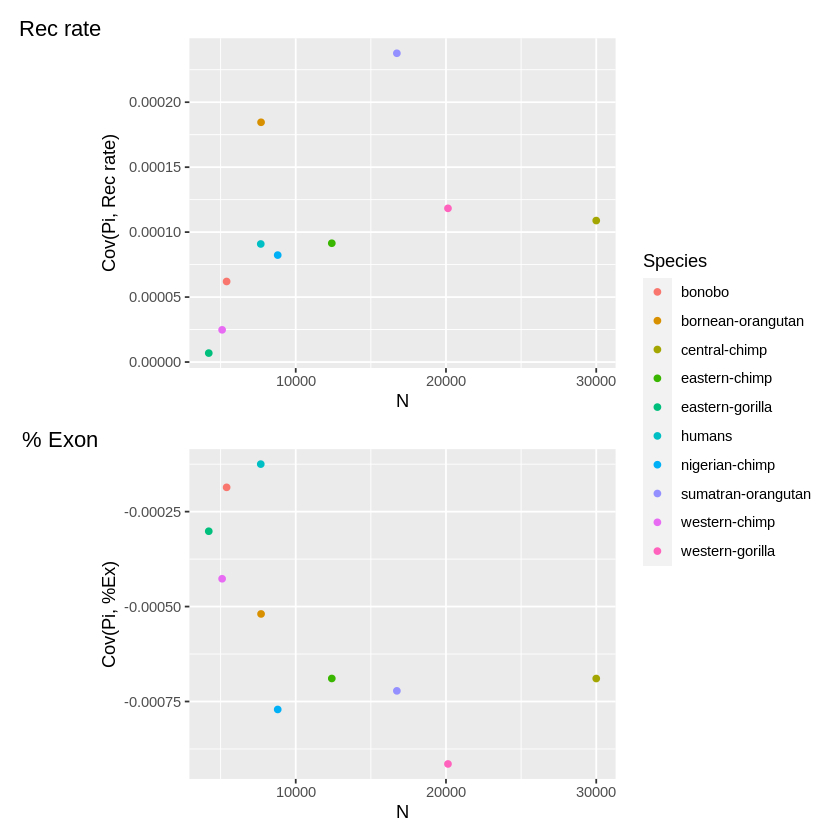

In [48]:
wrap_plots(cov_rec_pi_N, cov_ex_pi_N, guides="collect", nrow=2) + plot_annotation(tag_levels = list(c('Rec rate', '% Exon')))

In [49]:
summary(with(cov_rec[cov_rec$spp1==cov_rec$spp2,],
    lm(cov~N)))


Call:
lm(formula = cov ~ N)

Residuals:
       Min         1Q     Median         3Q        Max 
-6.673e-05 -4.297e-05 -1.180e-05  1.746e-06  1.193e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 5.855e-05  3.786e-05   1.546    0.161
N           3.573e-09  2.672e-09   1.337    0.218

Residual standard error: 6.61e-05 on 8 degrees of freedom
Multiple R-squared:  0.1826,	Adjusted R-squared:  0.08044 
F-statistic: 1.787 on 1 and 8 DF,  p-value: 0.218


In [50]:
summary(with(cov_ex[cov_ex$spp1==cov_ex$spp2,],
    lm(cov~N)))


Call:
lm(formula = cov ~ N)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.994e-04 -1.282e-04 -5.168e-05  1.795e-04  3.232e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -2.879e-04  1.236e-04  -2.330   0.0482 *
N           -2.087e-08  8.723e-09  -2.393   0.0436 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0002157 on 8 degrees of freedom
Multiple R-squared:  0.4172,	Adjusted R-squared:  0.3443 
F-statistic: 5.727 on 1 and 8 DF,  p-value: 0.04365


In [51]:
summary(with(cov_rec[cov_rec$spp1!=cov_rec$spp2,],
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.143e-04 -3.021e-05  6.340e-06  2.081e-05  1.549e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.105e-05  1.499e-05  -2.071   0.0445 *  
N            1.021e-08  5.604e-10  18.227   <2e-16 ***
dt           1.527e-10  6.684e-11   2.284   0.0275 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.44e-05 on 42 degrees of freedom
Multiple R-squared:  0.9892,	Adjusted R-squared:  0.9887 
F-statistic:  1922 on 2 and 42 DF,  p-value: < 2.2e-16


In [52]:
summary(with(cov_rec,
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.634e-04 -3.225e-05  8.152e-06  2.402e-05  1.525e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.268e-05  1.341e-05  -1.691  0.09682 .  
N            9.831e-09  5.948e-10  16.528  < 2e-16 ***
dt           1.897e-10  6.926e-11   2.738  0.00844 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.972e-05 on 52 degrees of freedom
Multiple R-squared:  0.9876,	Adjusted R-squared:  0.9871 
F-statistic:  2069 on 2 and 52 DF,  p-value: < 2.2e-16


In [53]:
summary(with(cov_ex[cov_ex$spp1!=cov_ex$spp2,],
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.805e-04 -8.531e-05  6.330e-05  1.622e-04  6.469e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.150e-03  1.091e-04 -10.540 2.28e-13 ***
N            3.135e-09  4.077e-09   0.769    0.446    
dt          -6.105e-10  4.863e-10  -1.255    0.216    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0003958 on 42 degrees of freedom
Multiple R-squared:  0.07038,	Adjusted R-squared:  0.02611 
F-statistic:  1.59 on 2 and 42 DF,  p-value: 0.216


In [54]:
summary(with(cov_ex,
    lm(cov~N+dt)))


Call:
lm(formula = cov ~ N + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0011261 -0.0001542  0.0001004  0.0002116  0.0007669 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -9.120e-04  9.496e-05  -9.604 4.11e-13 ***
N            2.649e-09  4.212e-09   0.629   0.5321    
dt          -8.532e-10  4.904e-10  -1.740   0.0878 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0004229 on 52 degrees of freedom
Multiple R-squared:  0.2242,	Adjusted R-squared:  0.1944 
F-statistic: 7.514 on 2 and 52 DF,  p-value: 0.00136


In [55]:
summary(with(cov_rec[cov_rec$spp1!=cov_rec$spp2,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.647e-04 -1.837e-04  5.454e-05  1.071e-04  2.166e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.070e-05  4.166e-05   1.457    0.152    
dt          1.303e-09  6.487e-11  20.087   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0001605 on 43 degrees of freedom
Multiple R-squared:  0.9037,	Adjusted R-squared:  0.9014 
F-statistic: 403.5 on 1 and 43 DF,  p-value: < 2.2e-16


In [56]:
summary(with(cov_ex[cov_ex$spp1!=cov_ex$spp2,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.523e-04 -1.563e-04  8.231e-05  2.106e-04  6.658e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.122e-03  1.023e-04 -10.968 4.86e-14 ***
dt          -2.574e-10  1.592e-10  -1.617    0.113    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0003939 on 43 degrees of freedom
Multiple R-squared:  0.05729,	Adjusted R-squared:  0.03537 
F-statistic: 2.613 on 1 and 43 DF,  p-value: 0.1133


In [57]:
summary(with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.516e-04 -2.220e-04  9.356e-05  1.342e-04  2.003e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.057e-05  6.353e-05   0.324    0.748    
dt          1.353e-09  8.972e-11  15.084   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0001727 on 35 degrees of freedom
Multiple R-squared:  0.8667,	Adjusted R-squared:  0.8629 
F-statistic: 227.5 on 1 and 35 DF,  p-value: < 2.2e-16


In [58]:
summary(with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,],
    lm(cov~dt)))


Call:
lm(formula = cov ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-6.734e-04 -4.616e-05  2.740e-06  9.472e-05  6.192e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.551e-03  1.201e-04 -12.916 7.07e-15 ***
dt           2.799e-10  1.696e-10   1.651    0.108    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0003265 on 35 degrees of freedom
Multiple R-squared:  0.07222,	Adjusted R-squared:  0.04571 
F-statistic: 2.724 on 1 and 35 DF,  p-value: 0.1078


In [59]:
pi_rec_m = summary(with(cov_rec[cov_rec$spp1 == cov_rec$spp2,],
    lm(cov~0+N)))

In [60]:
pi_ex_m = summary(with(cov_ex[cov_ex$spp1 == cov_ex$spp2,],
    lm(cov~0+N)))

In [61]:
cov_u_rec = pi_rec_m$coefficients[1] #(it's the cov*4)
cov_u_ex = pi_ex_m$coefficients[1]

In [62]:
cov_rec$cov2 = cov_rec$cov - (cov_u_rec*cov_rec$N)
cov_ex$cov2 = cov_ex$cov - (cov_u_ex*cov_ex$N)

In [63]:
with(cov_ex[cov_ex$spp1 != cov_ex$spp2,], lm(cov2~dt))


Call:
lm(formula = cov2 ~ dt)

Coefficients:
(Intercept)           dt  
 -7.819e-04    4.002e-09  


In [64]:
m_cov2_ex_noicp = with(cov_ex[cov_ex$spp1 != cov_ex$spp2,], lm(cov2~0+dt))
summary(m_cov2_ex_noicp)


Call:
lm(formula = cov2 ~ 0 + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0013499 -0.0011093 -0.0003309  0.0005792  0.0007484 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
dt 3.005e-09  1.963e-10   15.31   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0008455 on 44 degrees of freedom
Multiple R-squared:  0.842,	Adjusted R-squared:  0.8384 
F-statistic: 234.4 on 1 and 44 DF,  p-value: < 2.2e-16


In [65]:
with(cov_rec[cov_rec$spp1 != cov_rec$spp2,], lm(cov2~dt))


Call:
lm(formula = cov2 ~ dt)

Coefficients:
(Intercept)           dt  
 -2.341e-06    5.126e-10  


In [66]:
m_cov2_rec_noicp = with(cov_rec[cov_rec$spp1 != cov_rec$spp2,], lm(cov2~0+dt))
summary(m_cov2_rec_noicp)


Call:
lm(formula = cov2 ~ 0 + dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.066e-04 -5.043e-05  7.854e-06  4.168e-05  1.720e-04 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
dt 5.096e-10  1.644e-11   31.01   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.081e-05 on 44 degrees of freedom
Multiple R-squared:  0.9562,	Adjusted R-squared:  0.9552 
F-statistic: 961.4 on 1 and 44 DF,  p-value: < 2.2e-16


In [67]:
pi_ex_m


Call:
lm(formula = cov ~ 0 + N)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.382e-04 -2.265e-04 -1.478e-04 -8.650e-06  4.450e-04 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
N -3.782e-08  5.881e-09   -6.43 0.000121 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0002635 on 9 degrees of freedom
Multiple R-squared:  0.8212,	Adjusted R-squared:  0.8014 
F-statistic: 41.35 on 1 and 9 DF,  p-value: 0.0001209


In [68]:
pi_rec_m


Call:
lm(formula = cov ~ 0 + N)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.017e-04 -1.977e-05  1.247e-05  3.378e-05  1.305e-04 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)   
N 7.019e-09  1.585e-09   4.428  0.00165 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.102e-05 on 9 degrees of freedom
Multiple R-squared:  0.6854,	Adjusted R-squared:  0.6504 
F-statistic:  19.6 on 1 and 9 DF,  p-value: 0.001653


In [69]:
lines = unique(cov_ex[cov_ex$spp1 != cov_ex$spp2,c("mrca","N")])

In [70]:
lines$intercept_ex = pi_ex_m$coefficients[1] * lines$N

In [71]:
lines$intercept_rec = pi_rec_m$coefficients[1] * lines$N

In [72]:
lines$slope_ex = m_cov2_ex_noicp$coefficients[1]
lines$slope_rec = m_cov2_rec_noicp$coefficients[1]

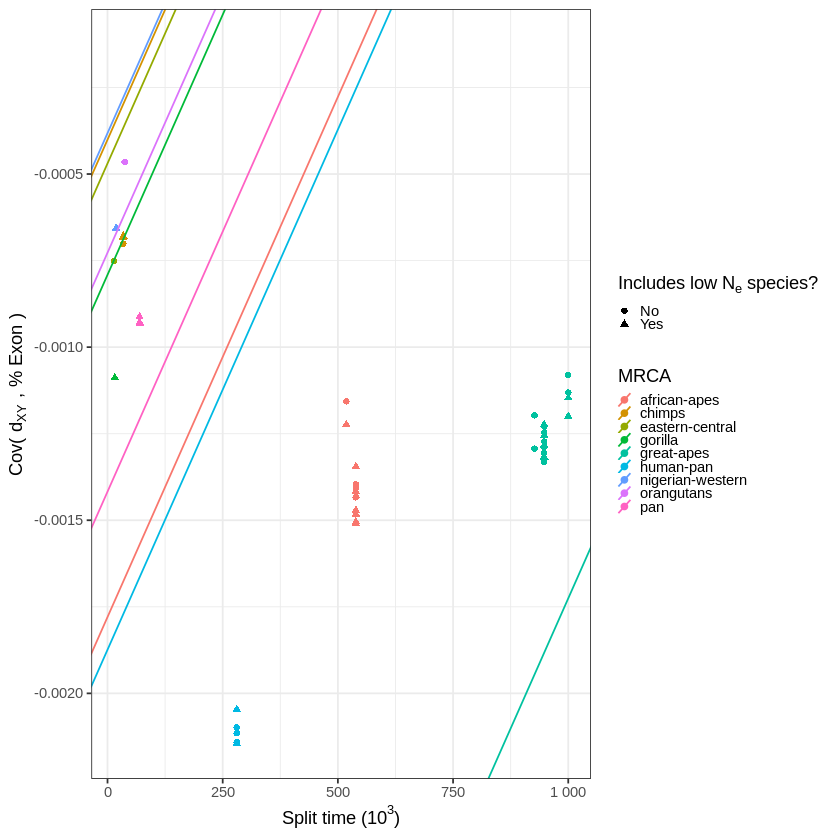

In [73]:
df = cov_ex
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
ylims=c(min(df$cov), max(df$cov))
annot="% Exon"
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")

    fit_annot_dxy_corr_ex = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims) +
        geom_abline(data=lines, aes(intercept=intercept_ex, slope=slope_ex, col=mrca))
fit_annot_dxy_corr_ex

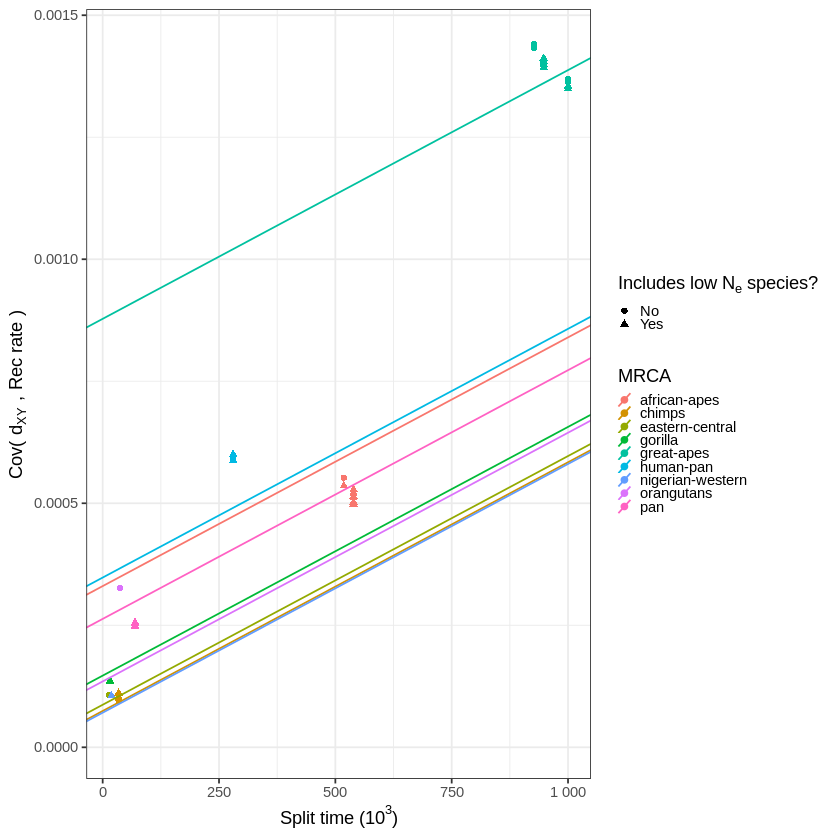

In [74]:
df = cov_rec
    pal09col=c("#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")
ylims=c(min(df$cov), max(df$cov))
annot="Rec rate"
    lownelabs = c(`TRUE`="Yes", `FALSE`="No")
    ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
    df$zlowne = apply(df, 1, function(x) x[1] %in% ne_spp) | apply(df, 1, function(x) x[2] %in% ne_spp)
    pal10col=c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527")

    fit_annot_dxy_corr_rec = ggplot(df[df$spp1!=df$spp2,], aes(y=cov, x=dt, shape=zlowne, col=mrca)) + 
        geom_point() + 
        my_theme +
        scale_shape_discrete(labels=lownelabs)+
        labs(shape=bquote("Includes low "*N[e]*" species?"), col="MRCA", y=bquote("Cov("~d[XY]~","~.(annot)~")"))+
        xlab(bquote("Split time ("*10^3*")"))+
        scale_x_continuous(labels = label_number(scale = 1e-3))+
        ylim(ylims) +
        geom_abline(data=lines, aes(intercept=intercept_rec, slope=slope_rec, col=mrca))
fit_annot_dxy_corr_rec

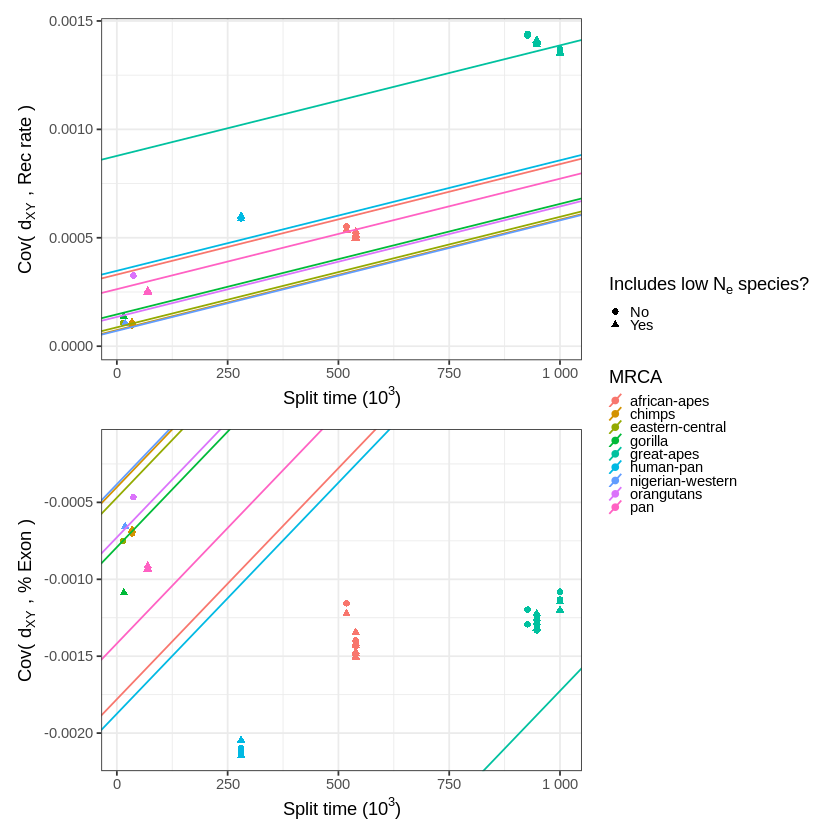

In [75]:
wrap_plots(fit_annot_dxy_corr_rec, fit_annot_dxy_corr_ex, nrow=2, guides="collect")

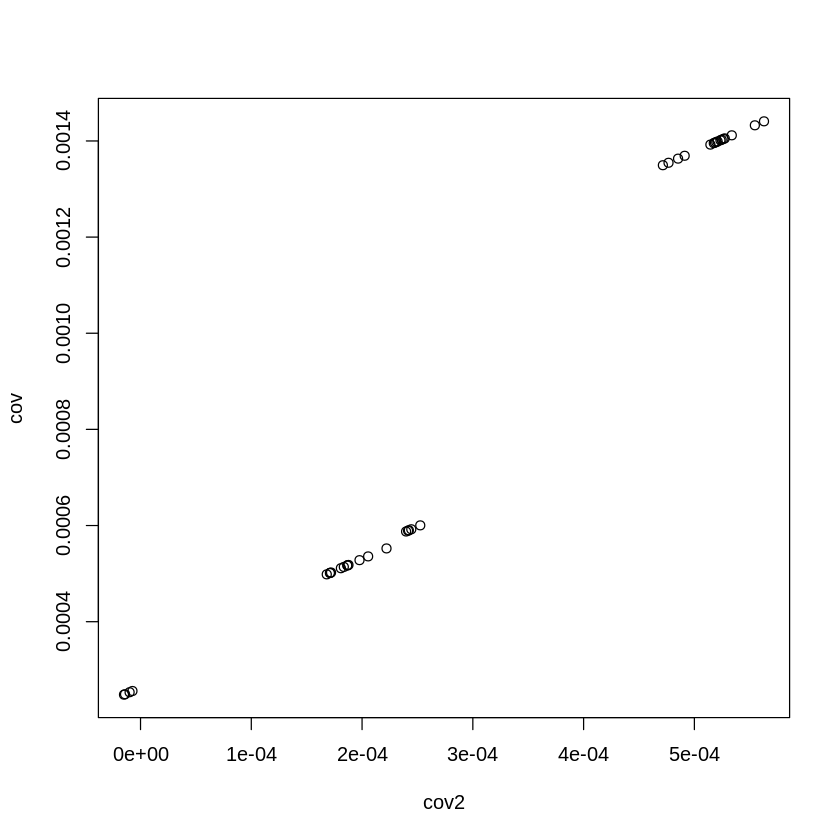

In [76]:
with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,], plot(cov2, cov))

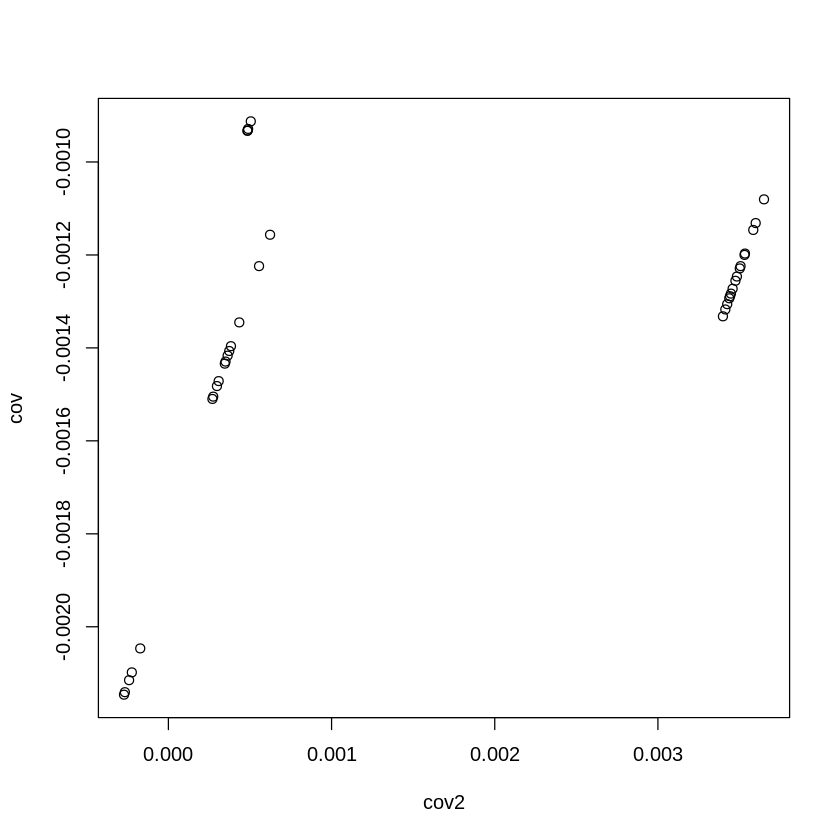

In [77]:
with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,], plot(cov2, cov))

In [78]:
summary(with(cov_rec[cov_rec$spp1 != cov_rec$spp2 & cov_rec$dt>37308,],
    lm(cov2~dt)))


Call:
lm(formula = cov2 ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.522e-05 -6.565e-05 -1.353e-05  3.685e-05  1.323e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.487e-05  2.640e-05  -1.321    0.195    
dt           5.533e-10  3.728e-11  14.839   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.178e-05 on 35 degrees of freedom
Multiple R-squared:  0.8629,	Adjusted R-squared:  0.8589 
F-statistic: 220.2 on 1 and 35 DF,  p-value: < 2.2e-16


In [79]:
summary(with(cov_ex[cov_ex$spp1 != cov_ex$spp2 & cov_ex$dt>37308,],
    lm(cov2~dt)))


Call:
lm(formula = cov2 ~ dt)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0009522 -0.0007875  0.0002459  0.0003773  0.0014376 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.252e-03  2.701e-04  -4.636 4.79e-05 ***
dt           4.590e-09  3.815e-10  12.033 5.41e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0007345 on 35 degrees of freedom
Multiple R-squared:  0.8053,	Adjusted R-squared:  0.7998 
F-statistic: 144.8 on 1 and 35 DF,  p-value: 5.413e-14


In [80]:
plot_dxy_land = function(df, label) {
    statlabs = c(`dxy`=label, `pi`="pi")
    subchr="chr12"
    spp_subset=c("humans", "bonobo", "bornean-orangutan", "western-gorilla", "central-chimp")
    col5pal = c("#ab62c0","#6ca659","#ca556a","#648ace","#c2843c")
    col4pal = c("#b98d3e","#9970c1","#64a860","#cc545e")
    subpidxy = df[chr==subchr & spp1 %in% spp_subset & spp2 %in% spp_subset & stat=="dxy"]
    subpidxy = subpidxy %>%
      mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
    subpidxy$label[duplicated(subpidxy$label)] = NA_character_

    p_land = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
                geom_point(aes(col=mrca), alpha=0.2, size=0.5)+
                geom_smooth(aes(col=mrca), span=1/4, se=FALSE,size=0.75) +
                facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed)) +
                scale_colour_manual(values=c(col5pal,col4pal)) +
                labs(y="Value", x="", col="") +
                theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
                guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
                geom_text_repel(aes(label = label, col=mrca),
                      nudge_x = 1,
                      na.rm = TRUE, force_pull=3.2, xlim=c(1.28e8,NA), size=2) +
                xlim(0, 1.58e8) + guides(color=FALSE) +
                my_theme
    return(p_land)
}


In [81]:
pidxy_path_wwss = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WWSS_prop-acc_0.4.tsv"


pidxy_wwss = fread(pidxy_path_wwss, header =T)

label = "d[XY]*' for W-W or S-S mutations'"
p_wwss = plot_dxy_land(pidxy_wwss, label)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


In [82]:
pidxy_path_ws = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_all_curr_WS_prop-acc_0.4.tsv"

pidxy_ws = fread(pidxy_path_ws, header =T)

label = "d[XY]*' for W-S mutations'"
p_ws = plot_dxy_land(pidxy_ws, label)

In [83]:
pdf(paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_wwss, p_ws, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

#ggsave(filename=paste0(outpath,"partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0, units = "in", dpi=300)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


png 
  2

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


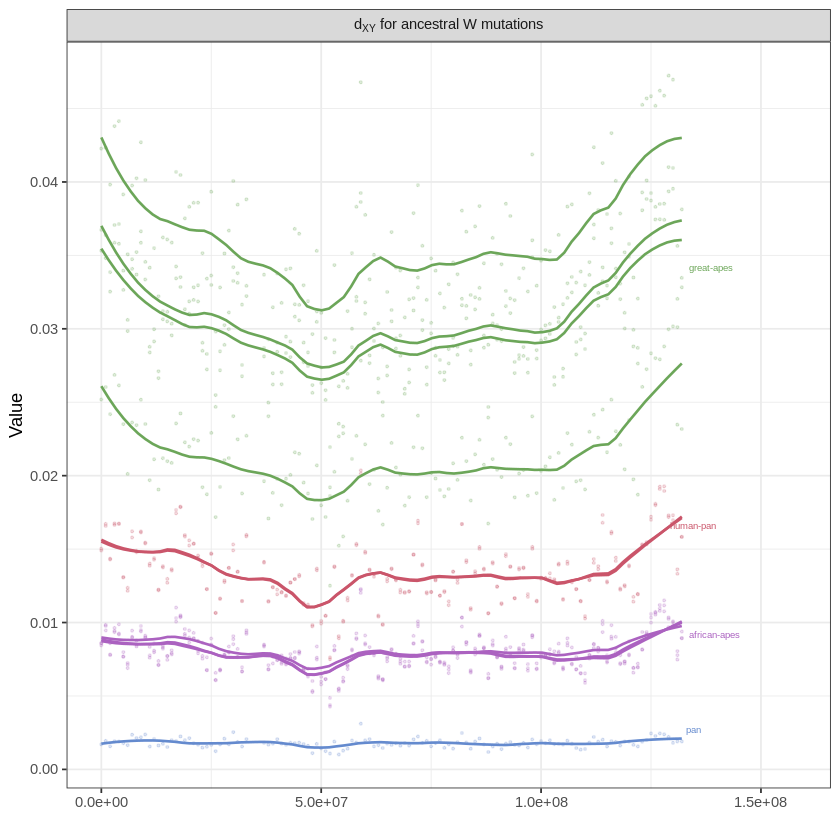

In [84]:
pidxy_path_at = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_A-T_curr_all_prop-acc_0.4.tsv"

pidxy_at = fread(pidxy_path_at, header =T)

label = "d[XY]*' for ancestral W mutations'"
p_at = plot_dxy_land(pidxy_at, label)
p_at

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


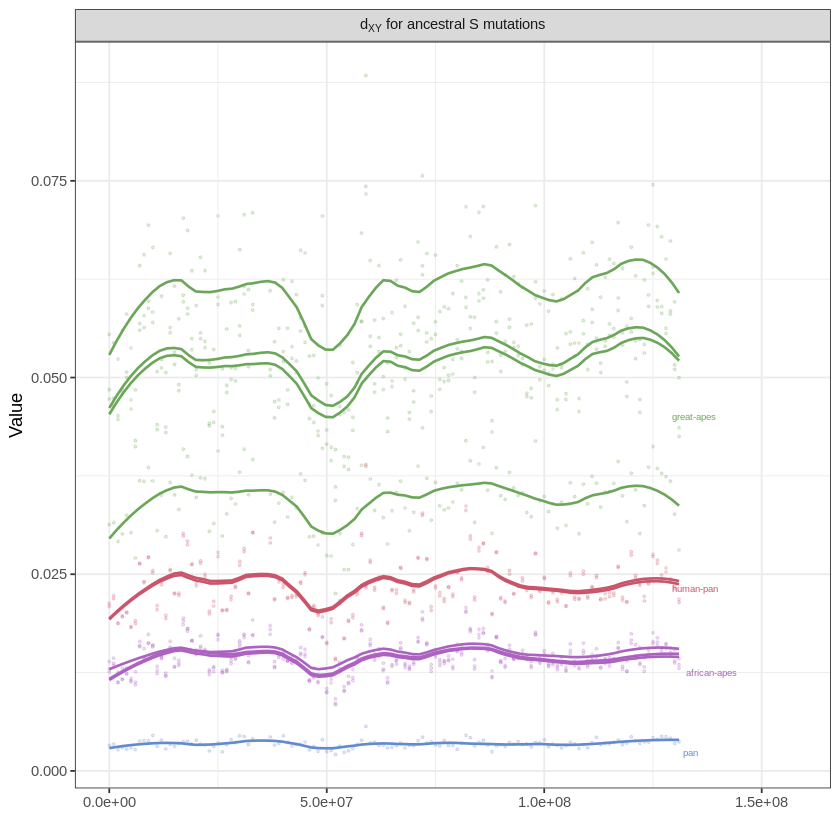

In [85]:
pidxy_path_gc = "../../output/greatapes-diversity-data/chr12/pidxy-filtered-withmetadata_win-size_1000000_merged-mask_True_state_G-C_curr_all_prop-acc_0.4.tsv"

pidxy_gc = fread(pidxy_path_gc, header =T)

label = "d[XY]*' for ancestral S mutations'"
p_gc = plot_dxy_land(pidxy_gc, label)
p_gc

In [86]:
pdf(paste0(outpath,"anc-partitioned_dxy_landscapes_data.pdf"), width = 3.5, height = 6.0)
wrap_plots(p_at, p_gc, nrow=2) + plot_annotation(tag_levels = 'A')
#grid::grid.draw(grid::textGrob("Value", x = 0.05, rot = 90))
grid::grid.draw(grid::textGrob("Window", y = 0.04, x=0.58))
dev.off()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


png 
  2

In [87]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WWSS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p1 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3, dxydxylab="d[XY]-d[XY]*' for W-W or S-S mutations'") + labs( y="")

rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_WS_prop-acc_",prop_acc, ".rds")
df = readRDS(rds_path)
p2 = corr_dt_panel(df[df$stat1=="dxy" & df$stat2=="dxy",], end=0.3,  dxydxylab="d[XY]-d[XY]*' for W-S mutations'")+ labs(y="")

In [88]:
pdf(paste0(outpath,"curr-partitioned-dxydxy-corr_data.pdf"), width = 6.5, height = 3.5)
(p1 + p2 & theme(legend.position = "none")) + plot_annotation(tag_levels = 'A')
grid::grid.draw(grid::textGrob("Correlation between landscapes", x = 0.03, rot = 90))
#grid::grid.draw(grid::textGrob("dT", y = 0.02, x=0.55))
dev.off()

png 
  2